# Air Brakes Example


In [1]:
from rocketpy import Environment, SolidMotor, Rocket, Flight, Function

In [2]:
%matplotlib inline

In [3]:
env = Environment(latitude=32.990254, longitude=-106.974998, elevation=1400)

In [4]:
Pro75M1670 = SolidMotor(
    thrust_source="../../data/motors/Cesaroni_M1670.eng",
    dry_mass=1.815,
    dry_inertia=(0.125, 0.125, 0.002),
    nozzle_radius=33 / 1000,
    grain_number=5,
    grain_density=1815,
    grain_outer_radius=33 / 1000,
    grain_initial_inner_radius=15 / 1000,
    grain_initial_height=120 / 1000,
    grain_separation=5 / 1000,
    grains_center_of_mass_position=0.397,
    center_of_dry_mass_position=0.317,
    nozzle_position=0,
    burn_time=3.9,
    throat_radius=11 / 1000,
    coordinate_system_orientation="nozzle_to_combustion_chamber",
)

In [5]:
calisto = Rocket(
    radius=127 / 2000,
    mass=14.426,
    inertia=(6.321, 6.321, 0.034),
    power_off_drag="../../data/calisto/powerOffDragCurve.csv",
    power_on_drag="../../data/calisto/powerOnDragCurve.csv",
    center_of_mass_without_motor=0,
    coordinate_system_orientation="tail_to_nose",
)

rail_buttons = calisto.set_rail_buttons(
    upper_button_position=0.0818,
    lower_button_position=-0.618,
    angular_position=45,
)

calisto.add_motor(Pro75M1670, position=-1.255)

nose_cone = calisto.add_nose(length=0.55829, kind="vonKarman", position=1.278)

fin_set = calisto.add_trapezoidal_fins(
    n=4,
    root_chord=0.120,
    tip_chord=0.060,
    span=0.110,
    position=-1.04956,
    cant_angle=0.5,
    airfoil=("../../data/calisto/NACA0012-radians.csv", "radians"),
)

tail = calisto.add_tail(
    top_radius=0.0635, bottom_radius=0.0435, length=0.060, position=-1.194656
)

In [6]:
def controller_function(time, sampling_rate, state, state_history, observed_variables, air_brakes):
    # state = [x, y, z, vx, vy, vz, e0, e1, e2, e3, wx, wy, wz]
    altitude_ASL = state[2]
    altitude_AGL = altitude_ASL - env.elevation
    vx, vy, vz = state[3], state[4], state[5]
    mach_number = (vx**2 + vy**2 + vz**2)**0.5 / env.speed_of_sound(altitude_AGL - env.elevation)

    # Get previous state from state_history
    previous_state = state_history[-1]
    previous_vz = previous_state[5]

    # Check if the rocket has reached burnout
    if time > Pro75M1670.burn_out_time:
        # If below 1500 meters above ground level, air_brakes are not deployed
        if altitude_AGL < 1500:
            air_brakes.set_deployed_level(0)

        # Else calculate the deployed level
        else:
            new_deployed_level = (
                air_brakes.deployed_level + 0.1 * vz + 0.01 * previous_vz**2
            )

            # Limiting the speed of the air_brakes to 0.1 per second
            # Since this function is called every 1/sampling_rate seconds
            # the max change in deployed level per call is 0.1/sampling_rate
            max_change = 0.2 / sampling_rate
            if new_deployed_level > air_brakes.deployed_level + max_change:
                new_deployed_level = air_brakes.deployed_level + max_change
            elif new_deployed_level < air_brakes.deployed_level - max_change:
                new_deployed_level = air_brakes.deployed_level - max_change

            air_brakes.set_deployed_level(new_deployed_level)
                  
        # Return variables of interest to be saved in the observed_variables list
        return time, air_brakes.deployed_level, air_brakes.drag_coefficient(air_brakes.deployed_level,mach_number)
    

In [7]:
air_brakes, controller = calisto.add_air_brakes(
    drag_coefficient_curve="../../data/calisto/air_brakes_cd.csv",
    controller_function=controller_function,
    sampling_rate=10,
    reference_area=None,
    clamp=True,
    name="AirBrakes",
    controller_name="AirBrakes Controller",
)

Air Break's geometric information:
--------------------------------------
Current deployed level: 0.00 = 0 %
Maximum Drag Coefficient: 1.100
Minimum Drag Coefficient: 0.000


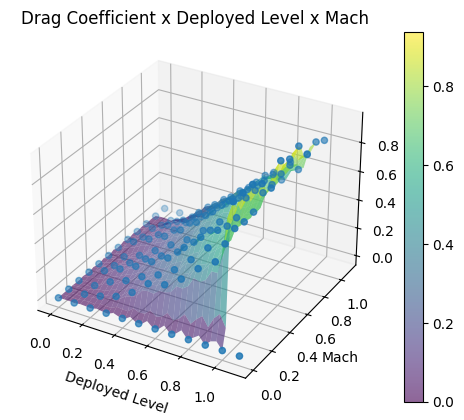

In [8]:
air_brakes.all_info()

In [9]:
test_flight = Flight(
    rocket=calisto,
    environment=env,
    rail_length=5.2,
    inclination=85,
    heading=0,
    time_overshoot=False,
    terminate_on_apogee=True,
)

## Analyzing the Results

Now we can see some plots from our air brakes:

In [ ]:
import matplotlib.pyplot as plt

time, deployed_level, drag_coefficient = [], [], []
for vars in controller.observed_variables:
    time.append(vars[0])
    deployed_level.append(vars[1])
    drag_coefficient.append(vars[2])
    
# plot deployed level by time
plt.plot(time, deployed_level)
plt.xlabel('Time (s)')
plt.ylabel('Deployed Level')
plt.title('Deployed Level by Time')
plt.show()

# plot drag coefficient by time
plt.plot(time, drag_coefficient)
plt.xlabel('Time (s)')
plt.ylabel('Drag Coefficient')
plt.title('Drag Coefficient by Time')
plt.show()



And of course, the simulation results:

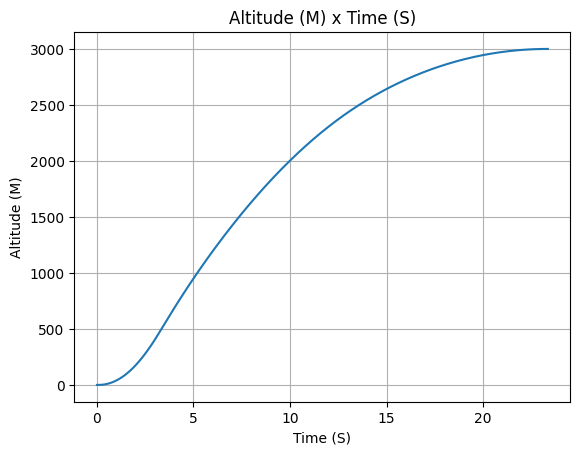

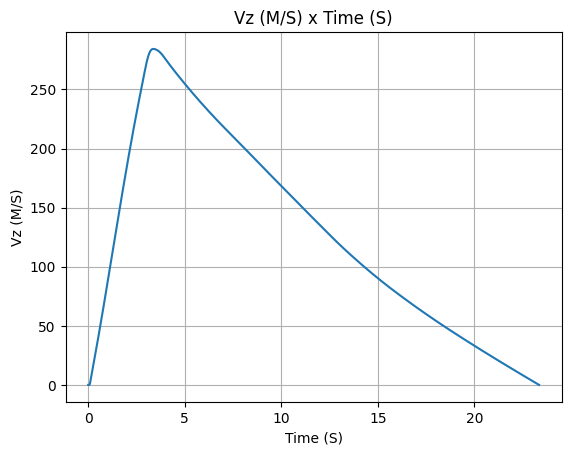

In [12]:
test_flight.altitude()
test_flight.vz()


Initial Conditions

Position - x: 0.00 m | y: 0.00 m | z: 1400.00 m
Velocity - Vx: 0.00 m/s | Vy: 0.00 m/s | Vz: 0.00 m/s
Attitude - e0: 0.999 | e1: -0.044 | e2: -0.000 | e3: 0.000
Euler Angles - Spin φ : 0.00° | Nutation θ: -5.00° | Precession ψ: 0.00°
Angular Velocity - ω1: 0.00 rad/s | ω2: 0.00 rad/s| ω3: 0.00 rad/s


Surface Wind Conditions

Frontal Surface Wind Speed: 0.00 m/s
Lateral Surface Wind Speed: 0.00 m/s


Launch Rail

Launch Rail Length: 5.2  m
Launch Rail Inclination: 85.00°
Launch Rail Heading: 0.00°


Rail Departure State

Rail Departure Time: 0.368 s
Rail Departure Velocity: 26.206 m/s
Rail Departure Stability Margin: 2.276 c
Rail Departure Angle of Attack: 0.000°
Rail Departure Thrust-Weight Ratio: 10.152
Rail Departure Reynolds Number: 2.040e+05


Burn out State

Burn out time: 3.900 s
Altitude at burn out: 657.355 m (AGL)
Rocket velocity at burn out: 279.590 m/s
Freestream velocity at burn out: 279.590 m/s
Mach Number at burn out: 0.843
Kinetic energy at burn out

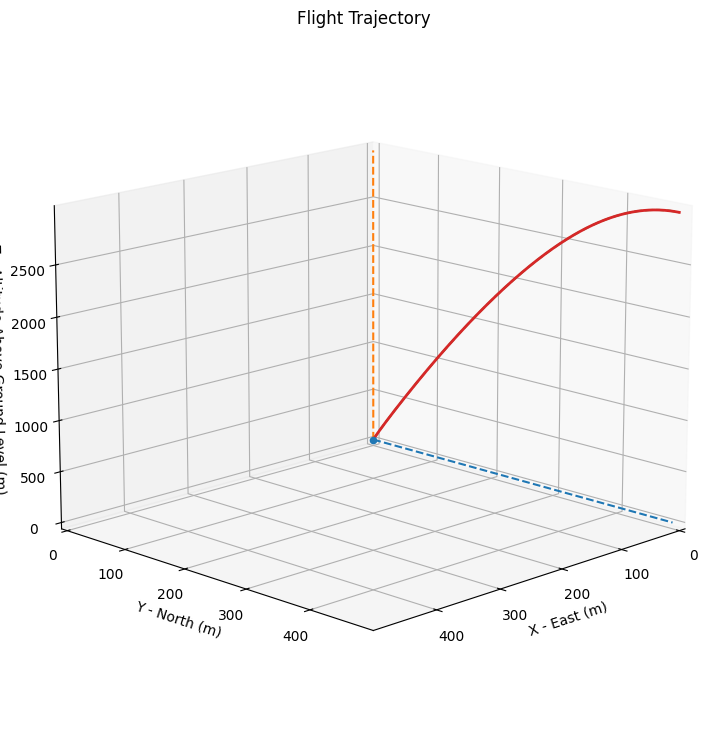



Trajectory Kinematic Plots



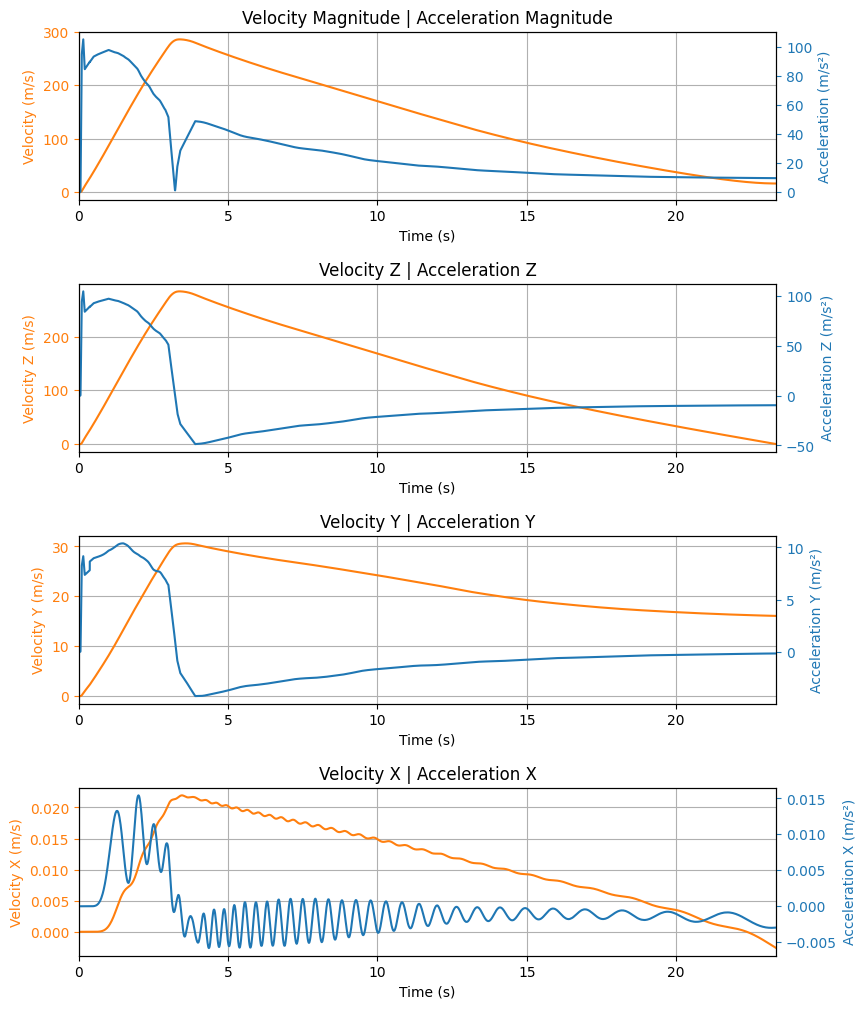



Angular Position Plots



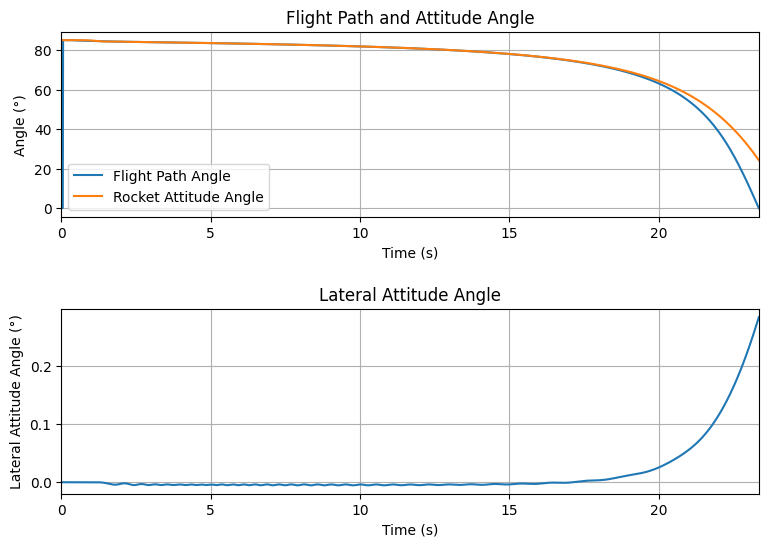



Path, Attitude and Lateral Attitude Angle plots



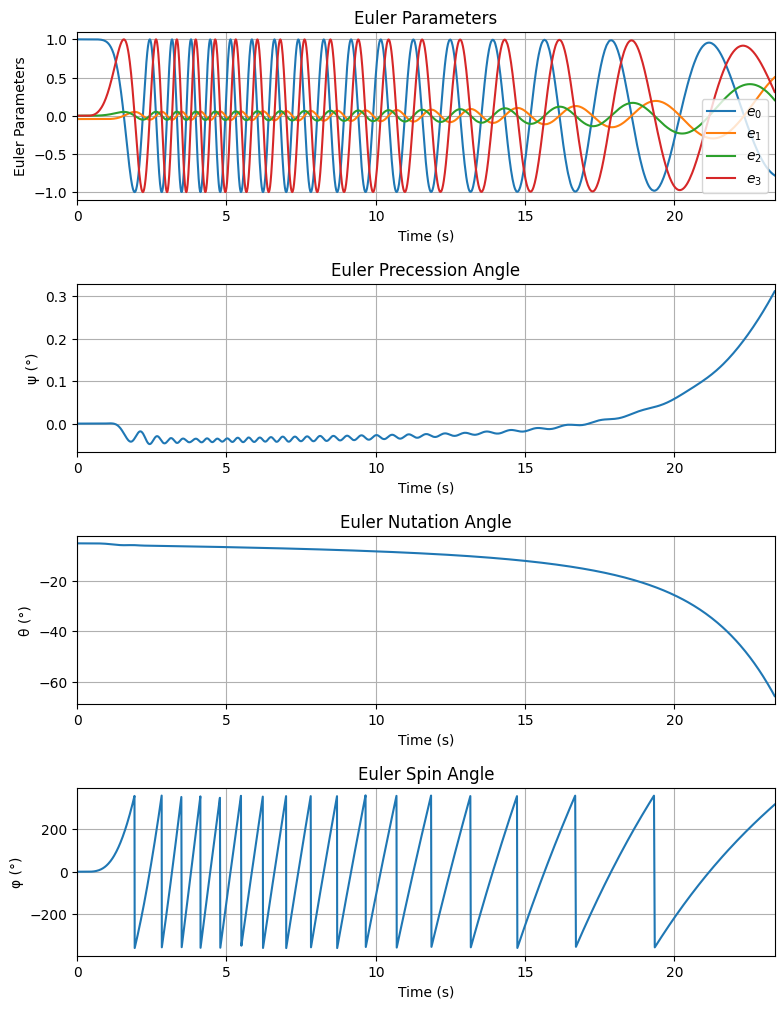



Trajectory Angular Velocity and Acceleration Plots



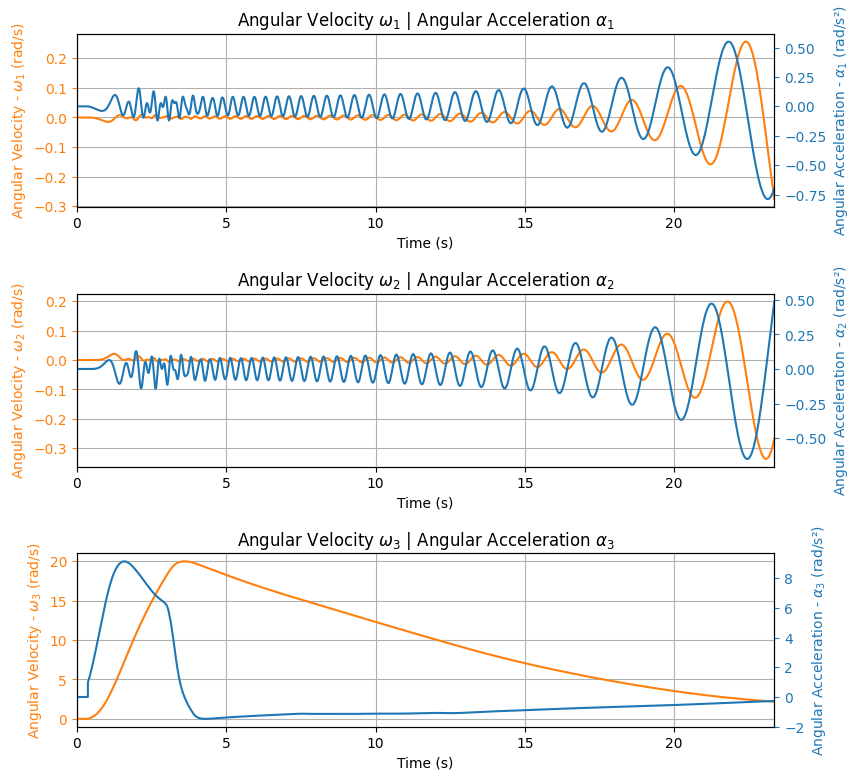



Aerodynamic Forces Plots



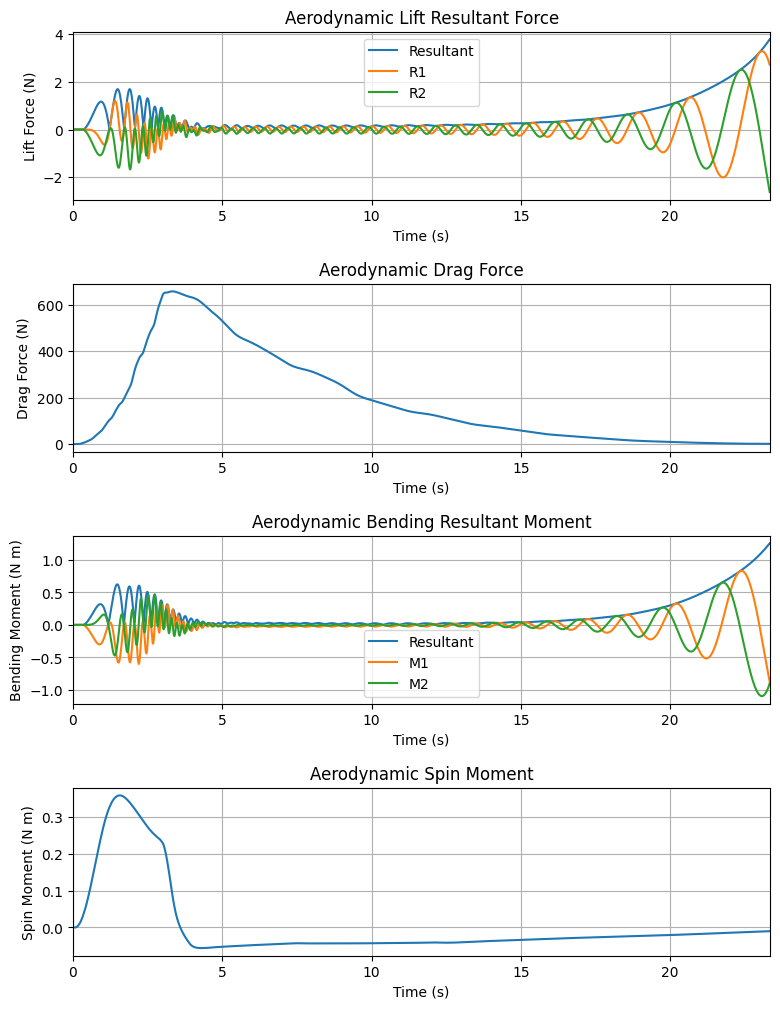



Rail Buttons Forces Plots



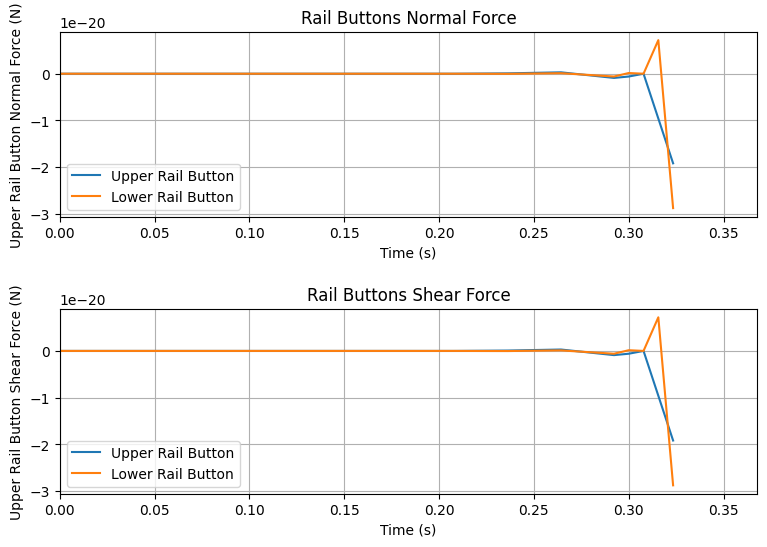



Trajectory Energy Plots



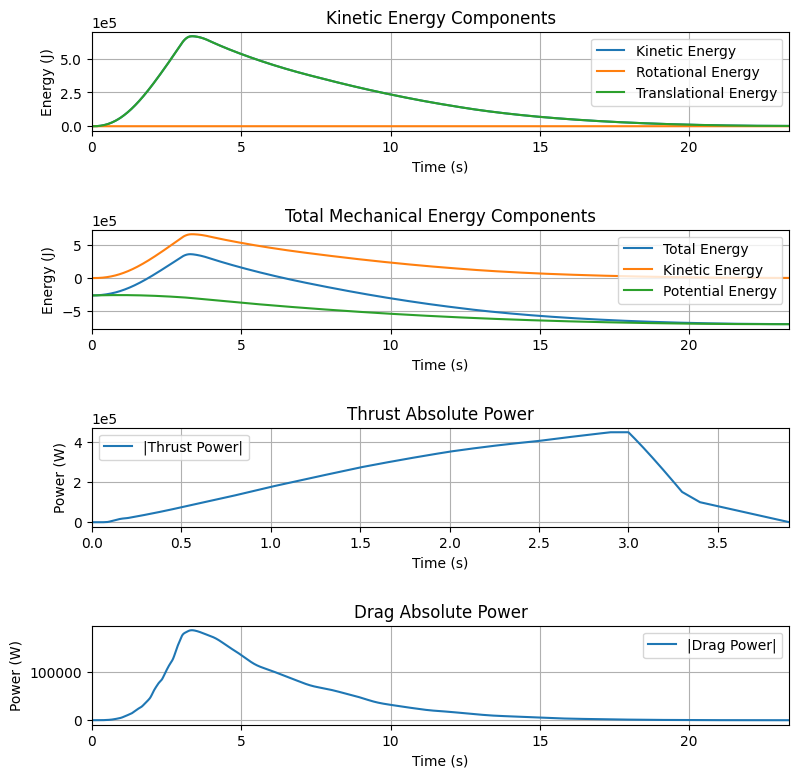



Trajectory Fluid Mechanics Plots



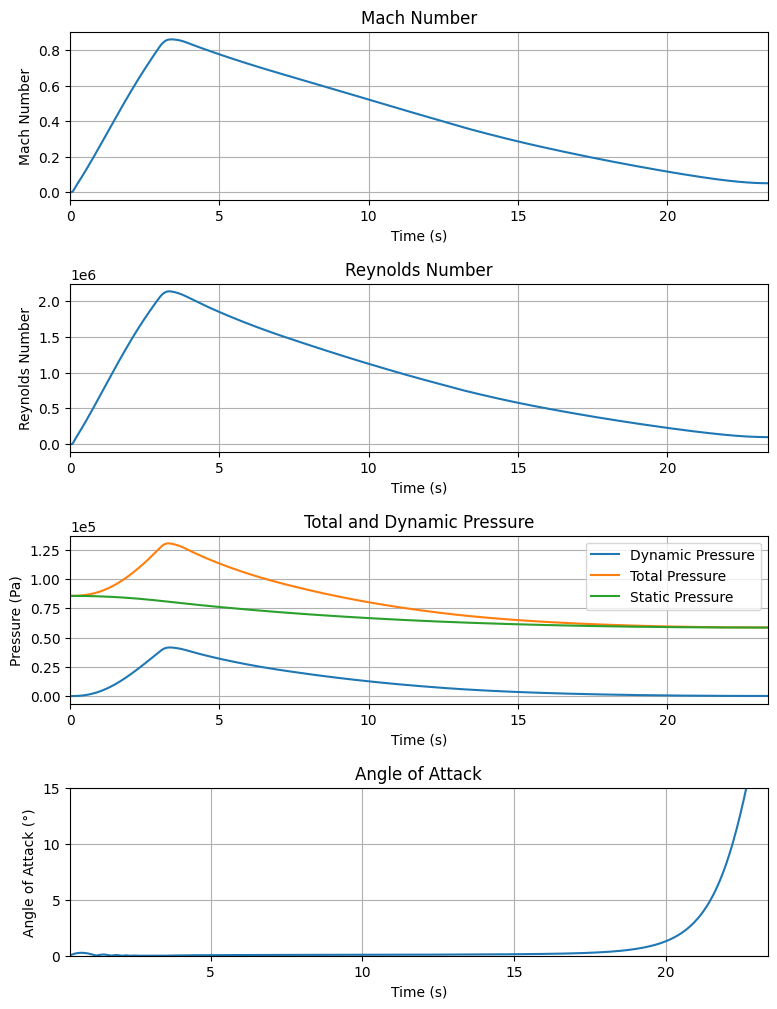



Trajectory Stability and Control Plots



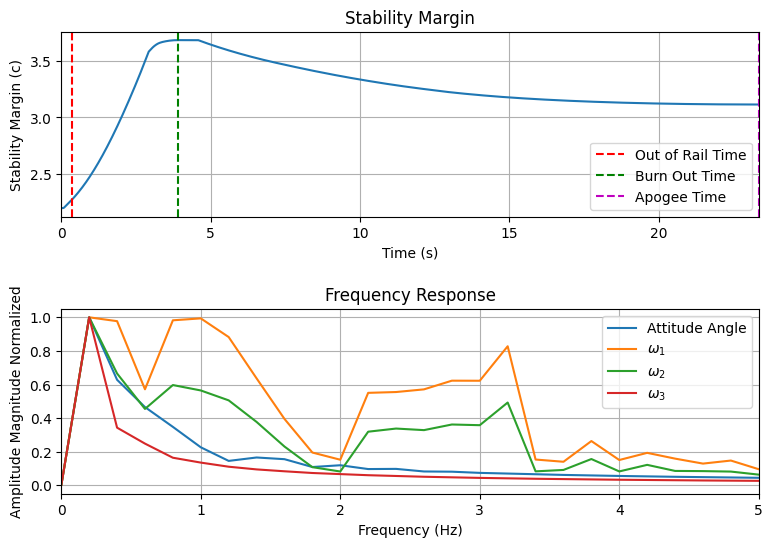



Rocket and Parachute Pressure Plots



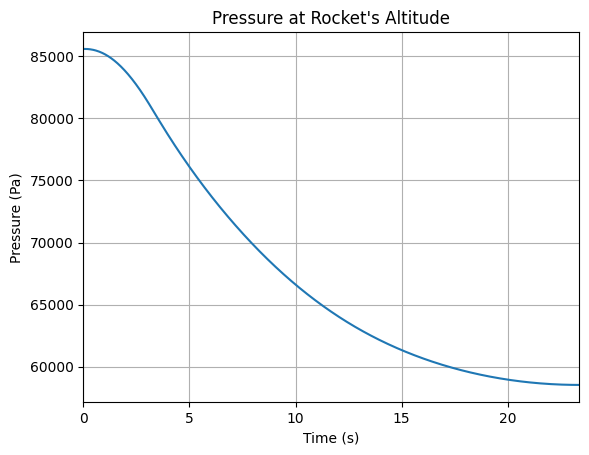


Rocket has no parachutes. No parachute plots available


In [13]:
test_flight.all_info()